In [2]:
import xarray as xr # Basic package to deal with data arrays
import xarray_sentinel # Handles most basic SAR operations
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
zarr_paths = sorted(glob.glob("/Users/devseed/Documents/repos/eopf-cpm/02_zarr_converted/*.zarr"))
datatrees = [xr.open_datatree(path, consolidated=True) for path in zarr_paths]
datasets = [xr.open_dataset(path, consolidated=True) for path in zarr_paths]

In [4]:
type(datatrees[2]) # this product S01SIWGRD_20241031T180256_0025_A322_479F_06E71E

xarray.core.datatree.DataTree

In [5]:
type(datatrees[2].groups[4]) # '/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VH/measurements'

str

In [6]:
# Create measurements list 
i = 0
measurements = []
while i < 19:
    measurements.append(datatrees[i][datatrees[i].groups[4]].to_dataset())
    i = i + 1

In [7]:
h = 0
grd = []
while h < 19:
    grd.append(measurements[h].grd)
    h = h + 1

In [8]:
# set(dat.ground_range.shape for dat in measurements) # to see if all measurements have the same shape

In [9]:
# Create GCP list 
j = 0
gcp = []
while j < 19:
    gcp.append(datatrees[j][datatrees[j].groups[14]].to_dataset())
    j = j + 1

In [10]:
grd[1] = grd[1].assign_coords({"latitude": gcp[1].latitude, "longitude": gcp[1].longitude})

In [27]:
grd[1]

<xarray.DataArray 'grd' (azimuth_time: 16677, ground_range: 26062)> Size: 869MB
[434635974 values with dtype=uint16]
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 133kB 2024-10-19T18:02:56.171...
  * ground_range  (ground_range) float64 208kB 0.0 10.0 ... 2.606e+05 2.606e+05
    line          (azimuth_time) float64 133kB 0.0 nan nan ... nan nan 1.668e+04
    pixel         (ground_range) float64 208kB 0.0 nan nan ... nan nan 2.606e+04
    latitude      (azimuth_time, ground_range) float64 3GB 38.07 nan ... 39.97
    longitude     (azimuth_time, ground_range) float64 3GB -2.536 ... 0.06271
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    measurement data set for GRD IW

In [26]:
grdd = grd[1].isel(
    longitude=slice(None, None, 10), latitude=slice(None, None, 10)
)
#grdd.plot(x="longitude", y="latitude", vmax=300)
#plt.show()

ValueError: Dimensions {'longitude', 'latitude'} do not exist. Expected one or more of ('azimuth_time', 'ground_range')

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

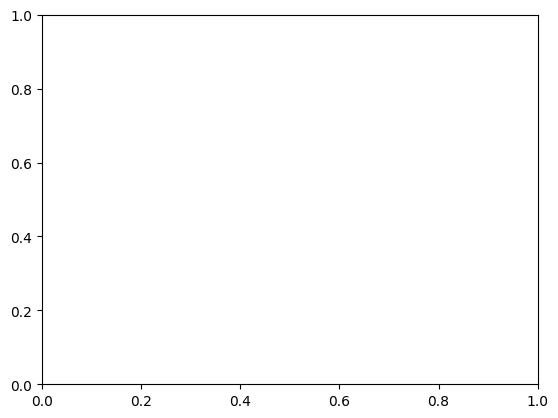

In [13]:
grd[1].plot(x="longitude", y="latitude", vmax=300)

In [48]:
# Create calibration list 
k = 0
calibration = []
while k < 19:
    calibration.append(datatrees[k][datatrees[k].groups[14]])
    k = k + 1

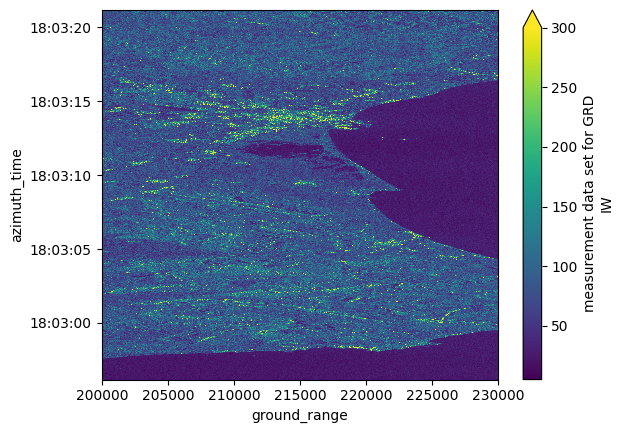

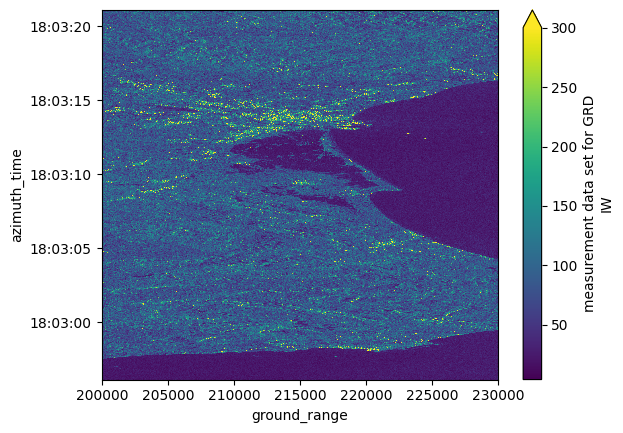

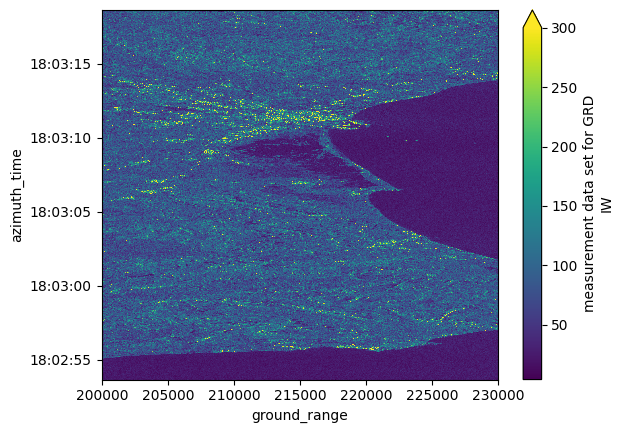

In [68]:
grd = [
    measurements[1].grd.sel(azimuth_time=slice(None, None, 5), ground_range=slice(200000, 230000, 5)), 
    measurements[2].grd.sel(azimuth_time=slice('2024-10-31T18:02:56.127918711', None, 5), ground_range=slice(200000, 230000, 5)), 
    measurements[5].grd.sel(azimuth_time=slice(None, None, 5), ground_range=slice(200000, 230000, 5))
]
for da in grd:
    da.plot(vmax=300)
    plt.show()

In [56]:
value = '2024-10-31T18:02:56.127918711'
index = grd[1].get_index("azimuth_time").get_loc(value)
print(index) 


1


In [59]:
grd[1].azimuth_time.shape

(1668,)

In [223]:
datatrees[2].groups[19] # '/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VH/quality/calibration'

'/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VH/quality/calibration'

In [189]:
product_names =[]
for i in datatrees:
    product_names.append(i)
    print(i)

<xarray.DataTree>
Group: /
│   Attributes:
│       other_metadata:  {'eopf_category': 'eocontainer', 'history': [{'output': ...
│       stac_discovery:  {'assets': {'S01SIWGRD_20241007T180256_0025_A320_D46B_06...
├── Group: /S01SIWGRD_20241007T180256_0025_A320_D46B_06D943_VH
│   │   Attributes:
│   │       other_metadata:  {'azimuth_steering_rate': 1.590368784, 'downlink_informa...
│   │       stac_discovery:  {'assets': {}, 'bbox': [0.38338, 38.065361, -2.926713, 3...
│   ├── Group: /S01SIWGRD_20241007T180256_0025_A320_D46B_06D943_VH/conditions
│   │   ├── Group: /S01SIWGRD_20241007T180256_0025_A320_D46B_06D943_VH/conditions/antenna_pattern
│   │   │       Dimensions:           (azimuth_time: 27, slant_range_time: 698)
│   │   │       Coordinates:
│   │   │         * azimuth_time      (azimuth_time) datetime64[ns] 216B 2024-10-07T18:02:56....
│   │   │           slant_range_time  (azimuth_time, slant_range_time) float64 151kB ...
│   │   │       Data variables:
│   │   │           ele

In [179]:
antes = product_names[2].groups[4]#.[product_names[1].groups[0]]
print(str(antes))

/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VH/measurements


In [180]:
measurements = datatrees[(antes)].to_dataset()

TypeError: list indices must be integers or slices, not str

In [152]:
#measurements_paths = [f"{name}/measurements" for name in product_names]
#for i in measurements_paths:
#    print(i)